In [76]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import re
from urllib.parse import quote
import time
%matplotlib inline

In [2]:
df=pd.read_csv('Orders.csv')
df.head()

D:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,DateId,MemberId,OrderGroupCode,TrackSourceTypeDef,TrackDeviceTypeDef,PayProfileTypeDef,SalesOrderSlaveId,SalePageId,IsMajor,IsGift,...,SalesOrderReceiverId,City,District,ZipCode,StoreName,StoreId,DeliverTypeDef,StatusDef,ReturnGoodsDateId,CauseDef
0,20150703,1388133,b'\xd0_\x8eby\xe8\x88\xa5\x85\xe4\x15\nMC\xeaO...,Web,Mobile,SevenEleven,4457777,1242871,True,False,...,1480890,嘉義縣,水上鄉,608.0,中庄門市,910828,SevenEleven,Finish,NaN,NaN
1,20150703,1388133,b'\xd0_\x8eby\xe8\x88\xa5\x85\xe4\x15\nMC\xeaO...,Web,Mobile,SevenEleven,4457778,1242880,True,False,...,1480890,嘉義縣,水上鄉,608.0,中庄門市,910828,SevenEleven,Finish,NaN,NaN
2,20150703,1388133,b'\xd0_\x8eby\xe8\x88\xa5\x85\xe4\x15\nMC\xeaO...,Web,Mobile,SevenEleven,4457779,1242880,True,False,...,1480890,嘉義縣,水上鄉,608.0,中庄門市,910828,SevenEleven,Finish,NaN,NaN
3,20150703,1388133,b'\xd0_\x8eby\xe8\x88\xa5\x85\xe4\x15\nMC\xeaO...,Web,Mobile,SevenEleven,4457780,1175574,True,False,...,1480890,嘉義縣,水上鄉,608.0,中庄門市,910828,SevenEleven,Finish,NaN,NaN
4,20150703,365787,"b""\x04?}pe$m\x7f\x85\xa0y\x81'e5\xca\xbb\xf9\x...",Web,Mobile,SevenEleven,4457791,1194488,True,False,...,1480896,桃園市,中壢區,320.0,復華門市,114071,SevenEleven,Finish,NaN,NaN


In [3]:
df['new_DateId'] = pd.to_datetime(df['DateId'].astype(str), format='%Y%m%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5495276 entries, 0 to 5495275
Data columns (total 29 columns):
DateId                         int64
MemberId                       int64
OrderGroupCode                 object
TrackSourceTypeDef             object
TrackDeviceTypeDef             object
PayProfileTypeDef              object
SalesOrderSlaveId              int64
SalePageId                     int64
IsMajor                        bool
IsGift                         bool
IsSalePageGift                 bool
Quantity                       int64
UnitPrice                      float64
PromotionDiscount              float64
ECouponId                      int64
ECouponDiscount                float64
SalesOrderSlaveTotalPayment    float64
SalesOrderSlaveDateTime        object
SalesOrderReceiverId           int64
City                           object
District                       object
ZipCode                        float64
StoreName                      object
StoreId              

In [4]:

df_clean=df.dropna(subset=['City'])
df_clean = df_clean.drop(df_clean[(df_clean['City'] < '\u4e00' )].index).drop(df_clean[(df_clean['City'] > '\u9fff' )].index)
def new_city(city):
    if city =='桃園縣':
        return '桃園市'
        
    elif city == '台北縣':        
        return  '新北市'
        
    elif city == '台東市':
        return  '台東縣'
            
    elif city == '屏東市':        
        return  '屏東縣'
        
    elif city == '台南縣':        
        return  '台南市'
    else:
        return city
df_clean['City']=df_clean['City'].apply(new_city)
df_clean.groupby(by='City')['Quantity'].sum()

City
南投縣      74939
台中市     815918
台北市     705464
台南市     407470
台東縣      35217
嘉義市      55276
嘉義縣      68262
基隆市      89367
宜蘭縣      87111
屏東縣     125897
彰化縣     201898
新北市    1196609
新竹市     148414
新竹縣     129924
桃園市     599553
澎湖縣      20190
花蓮縣      69475
苗栗縣     108647
雲林縣      88407
高雄市     580556
Name: Quantity, dtype: int64

In [5]:
df_clean.groupby(by='City')['SalesOrderSlaveTotalPayment'].sum()

City
南投縣     17134346.0
台中市    187208076.0
台北市    165698588.0
台南市     92564746.0
台東縣      8126489.0
嘉義市     12708676.0
嘉義縣     15366003.0
基隆市     20754873.0
宜蘭縣     20081791.0
屏東縣     28304855.0
彰化縣     45623618.0
新北市    279141059.0
新竹市     34368832.0
新竹縣     30437498.0
桃園市    139400885.0
澎湖縣      4596791.0
花蓮縣     15956499.0
苗栗縣     24881734.0
雲林縣     19942376.0
高雄市    131871054.0
Name: SalesOrderSlaveTotalPayment, dtype: float64

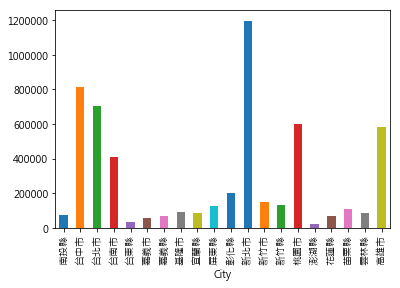

In [6]:
df_clean_city=df_clean.groupby(by='City')['Quantity'].sum()
df_clean_city.plot.bar()

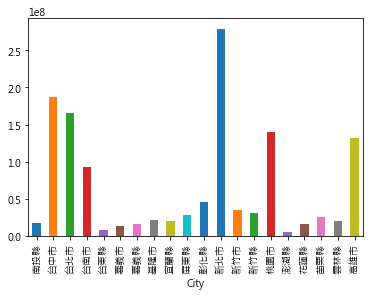

In [7]:
df_clean_city_pay=df_clean.groupby(by='City')['SalesOrderSlaveTotalPayment'].sum()
df_clean_city_pay.plot.bar()

In [13]:
date='201809017'
url='http://www.twse.com.tw/exchangeReport/MI_INDEX?response=json&date='+date+'&type=MS&_='
html = requests.get(url)
html.text

'{"data4":[["上漲(漲停)","2,711(12)","295(7)"],["下跌(跌停)","4,216(30)","504(1)"],["持平","680","100"],["未成交","7,402","8"],["無比價","957","7"]],"notes4":["\\"漲跌價差\\"為當日收盤價與前一日收盤價比較。","\\"無比價\\"含前一日無收盤價、當日除權、除息、新上市、恢復交易者。","外幣成交值係以本公司當日下午3時30分公告匯率換算後加入成交金額。<br>公告匯率請參考本公司首頁>交易資訊>雙幣ETF專區>代號對應及每日公告匯率。"],"subtitle4":"漲跌證券數合計","fields1":["指數","收盤指數","漲跌(+/-)","漲跌點數","漲跌百分比(%)"],"fields2":["報酬指數","收盤指數","漲跌(+/-)","漲跌點數","漲跌百分比(%)"],"alignsStyle4":[["center","center","center"],["left","right","right"],[16,12,12]],"subtitle1":"107年09月17日 大盤統計資訊","date":"20180917","alignsStyle1":[["center","center","center","center","center"],["left","right","center","right","right"],[16,8,8,4,12]],"data2":[["寶島股價報酬指數","14,843.41","<p style =\'color:green\'>-<\\u002fp>","51.66","-0.35"],["發行量加權股價報酬指數","19,309.26","<p style =\'color:green\'>-<\\u002fp>","70.43","-0.36"],["臺灣公司治理100報酬指數","7,305.96","<p style =\'color:green\'>-<\\u002fp>","33.06","-0.45"],["臺灣50報酬指數","14,983.70","<p style =\'color:green\'>-<\\u002fp>","71.39"

In [38]:
re_result = re.search('臺灣50指數",".*臺灣中型100指數',html.text)
a=str(re_result.group(0))
b=a.split(',')[1].replace('"','')
c=a.split(',')[2].replace('"','')
d=float(b)*1000+float(c)
d

8311.95

In [39]:
date='201809002'
url='http://www.twse.com.tw/exchangeReport/MI_INDEX?response=json&date='+date+'&type=MS&_='
html = requests.get(url)
html.text

'{"stat":"很抱歉，沒有符合條件的資料!"}'

In [85]:
date=20150920
date=str(date)
url='http://www.twse.com.tw/exchangeReport/MI_INDEX?response=json&date='+date+'&type=MS&_='
html = requests.get(url)
html.text

'{"stat":"很抱歉，沒有符合條件的資料!"}'

In [96]:
def stock(date):
    date=str(date)
    while True:
        url='http://www.twse.com.tw/exchangeReport/MI_INDEX?response=json&date='+date+'&type=MS&_='
        html = requests.get(url)
        time.sleep(0.5)
        if html.text == '{"stat":"很抱歉，沒有符合條件的資料!"}':
            date=str(int(date)-1)
            continue
        else:
            re_result = re.search('臺灣50指數",".*臺灣中型100指數',html.text)
            a=str(re_result.group(0))
            b=a.split(',')[1].replace('"','')
            c=a.split(',')[2].replace('"','')
            d=float(b)*1000+float(c)
            break
    return d


In [95]:
date='201809002'
url='http://www.twse.com.tw/exchangeReport/MI_INDEX?response=json&date='+date+'&type=MS&_='
html = requests.get(url)
html.text

ConnectionError: HTTPConnectionPool(host='www.twse.com.tw', port=80): Max retries exceeded with url: /exchangeReport/MI_INDEX?response=json&date=201809002&type=MS&_= (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000000006952BA8>: Failed to establish a new connection: [WinError 10061] 無法連線，因為目標電腦拒絕連線。',))

In [89]:
stock(20150921)

6140.5

In [43]:
df_city=df_clean.groupby('City')
df_tpe=df_city.get_group('台北市')
df_tpe

,DateId,MemberId,OrderGroupCode,TrackSourceTypeDef,TrackDeviceTypeDef,PayProfileTypeDef,SalesOrderSlaveId,SalePageId,IsMajor,IsGift,...,City,District,ZipCode,StoreName,StoreId,DeliverTypeDef,StatusDef,ReturnGoodsDateId,CauseDef,new_DateId
35,20150703,1388138,b'$@BN\xe5\x13\x87A\x94x?A\xde\xc6t\xbe\x81\x9...,Web,PC,SevenEleven,4457962,1119593,True,False,...,台北市,中山區,104.0,松運門市,972778,SevenEleven,Finish,NaN,NaN,2015-07-03
36,20150703,1388138,b'$@BN\xe5\x13\x87A\x94x?A\xde\xc6t\xbe\x81\x9...,Web,PC,SevenEleven,4457963,1119593,True,False,...,台北市,中山區,104.0,松運門市,972778,SevenEleven,Finish,NaN,NaN,2015-07-03
37,20150703,1388138,b'$@BN\xe5\x13\x87A\x94x?A\xde\xc6t\xbe\x81\x9...,Web,PC,SevenEleven,4457964,1194586,True,False,...,台北市,中山區,104.0,松運門市,972778,SevenEleven,Finish,NaN,NaN,2015-07-03
38,20150703,1388138,b'$@BN\xe5\x13\x87A\x94x?A\xde\xc6t\xbe\x81\x9...,Web,PC,SevenEleven,4457965,1194586,True,False,...,台北市,中山區,104.0,松運門市,972778,SevenEleven,Finish,NaN,NaN,2015-07-03
39,20150703,1388138,b'$@BN\xe5\x13\x87A\x94x?A\xde\xc6t\xbe\x81\x9...,Web,PC,SevenEleven,4457966,1162456,True,False,...,台北市,中山區,104.0,松運門市,972778,SevenEleven,Finish,NaN,NaN,2015-07-03
40,20150703,1370967,b'\xcd\x89\x19.\xfd\xdeX\xacf\xedu\xa5>\xcd\x8...,AndroidApp,Mobile,SevenEleven,4457994,1224314,True,False,...,台北市,大安區,106.0,中廣門市,140612,SevenEleven,Finish,NaN,NaN,2015-07-03
41,20150703,1370967,b'\xcd\x89\x19.\xfd\xdeX\xacf\xedu\xa5>\xcd\x8...,AndroidApp,Mobile,SevenEleven,4457995,1224314,True,False,...,台北市,大安區,106.0,中廣門市,140612,SevenEleven,Finish,NaN,NaN,2015-07-03
42,20150703,1370967,b'\xcd\x89\x19.\xfd\xdeX\xacf\xedu\xa5>\xcd\x8...,AndroidApp,Mobile,SevenEleven,4457996,1194488,True,False,...,台北市,大安區,106.0,中廣門市,140612,SevenEleven,Finish,NaN,NaN,2015-07-03
43,20150703,1370967,b'\xcd\x89\x19.\xfd\xdeX\xacf\xedu\xa5>\xcd\x8...,AndroidApp,Mobile,SevenEleven,4457997,1209881,True,False,...,台北市,大安區,106.0,中廣門市,140612,SevenEleven,Finish,NaN,NaN,2015-07-03
86,20150703,139475,b'\x05\x0e\x82\xa9V\t\xc6+\x9fs8\x02\xb3\xdb\x...,Web,Mobile,SevenEleven,4457402,1242902,True,False,...,台北市,松山區,105.0,延新門市,161402,SevenEleven,Finish,NaN,NaN,2015-07-03


In [55]:
df_tpe_pay=df_tpe.groupby('DateId')['SalesOrderSlaveTotalPayment'].sum()
df_tpe_pay=df_tpe_pay.to_frame().reset_index()
df_tpe_pay

,DateId,SalesOrderSlaveTotalPayment
0,20150507,1470.0
1,20150508,717.0
2,20150509,1032.0
3,20150510,3521.0
4,20150511,3198.0
5,20150512,4304.0
6,20150513,1075.0
7,20150515,2607.0
8,20150516,1623.0
9,20150517,1736.0


In [90]:
df_tpe_pay['Stock']=df_tpe_pay['DateId'].apply(stock)
df_tpe_pay

AttributeError: 'NoneType' object has no attribute 'group'